# Diffusion transformer

Instead of parameterizing the noise predictor using a U-Net, Peebles et al., in "Scalable Diffusion Models with Transformers", proposes parameterizing the noise using a transformer. The architecture of the diffusion transformer (DiT) is shown below. Overall, it is very similar to other transformer architectures such as iGPT.

<div style="display: flex; justify-content: center;">
 <img src="/Users/raymondtsao/Desktop/UnsupervisedLearningNotes/notes/Diffusion/figures/dit.png" style="max-width: 65%; height: auto;">  
</div>

<p style="text-align: center; font-size: 14px; margin-top: 20px;"> 
    <strong> Figure 1 </strong>: Diffusion transformer architecture
</p>


Training a transformer on high resolution images can be computationally expensive. Therefore, the authors propose first learning an autoencoder that compresses images into smaller spatial representations. The DiT is then trained on the compressed images. New images can be sampled by first sampling in the latent space, apply DiT, and then apply decoder to map the latent back to the image space. The noised latent, before passing into the DiT, is passed into a patch emebding layer similar to the tratment in vision transformer. 

## Diffusion transformer implementation

We implement and test DiT on CIFAR10 dataset. We used a pretrained convolutional VAE to encoded the CIFAR10 images. Before encoding the images, we normalize it to the range of $[-1, 1]$. To ensure that the latents also lies in this range, we estimated the standard devition of the trained latent and scale the encoded image before passing it to DiT. Similar to the previous section, we train the DiT with classifier free guidance. 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

vae = load_pretrain_vae()

def encode(X, vae=vae):
    vae.eval()
    with torch.no_grad():
        return vae.encode(X)

def decode(X, vae=vae):
    vae.eval()
    with torch.no_grad():
        return vae.decode(X)
    
def estimate_scale_factor(train_dataset):
    train_loader = DataLoader(train_dataset, batch_size=1000, shuffle=True)
    X = next(iter(train_loader))[0].to(DEVICE)
    encoded = encode(X).reshape(-1)
    encoded = encoded.detach().cpu().numpy()
    return np.std(encoded)

### Patch Embedding Implementation

In [7]:
class PatchEmbed(nn.Module):
    def __init__(self, height, width, patch_dim, in_channels, hidden_dim, bias=True):
        super(PatchEmbed, self).__init__()
        n_patches = (height // patch_dim) * (width // patch_dim)
        self.proj = nn.Conv2d(in_channels, hidden_dim, kernel_size=(patch_dim, patch_dim), stride=patch_dim, bias=bias)
        self.norm = nn.LayerNorm(hidden_dim, elementwise_affine=False)

    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2).transpose(1, 2)
        x = self.norm(x)
        return x

### DiT Block Implementation

In [9]:
class DiTBlock(nn.Module):
    ## Input: Embedded x: [B, L, D], Embedded label+timestep c: [B, D] ==> [B, L, D]
    def __init__(self, hidden_dim, n_heads):
        super(DiTBlock, self).__init__()
        self.adaln_mlp = nn.Sequential(nn.SiLU(),
                                       nn.Linear(hidden_dim, 6*hidden_dim))
        self.layer_norm1 = nn.LayerNorm(hidden_dim, elementwise_affine=False)
        self.layer_norm2 = nn.LayerNorm(hidden_dim, elementwise_affine=False)
        self.attn = MultiHeadSelfAttention(hidden_dim, n_heads)
        self.mlp = nn.Sequential(nn.Linear(hidden_dim, 4 * hidden_dim),
                                 nn.Linear(4 * hidden_dim, hidden_dim),
                                 nn.GELU(),
                                 nn.Dropout(0.1)
        )

    def forward(self, x, c):
        c = self.adaln_mlp(c)
        shift_msa, scale_msa, gate_msa, shift_mlp, scale_mlp, gate_mlp = c.chunk(6, dim=1)
        h = modulate(self.layer_norm1(x), shift_msa, scale_msa)
        x = x + gate_msa.unsqueeze(1) * self.attn(h)
        h = modulate(self.layer_norm2(x), shift_mlp, scale_mlp)
        x = x + gate_mlp.unsqueeze(1) * self.mlp(h)
        return x
    
class FinalLayer(nn.Module):
    def __init__(self, hidden_dim, patch_dim, out_channels):
        super(FinalLayer, self).__init__()
        self.adaln_mlp = nn.Sequential(nn.SiLU(),
                                       nn.Linear(hidden_dim, 2*hidden_dim))
        self.layer_norm = nn.LayerNorm(hidden_dim, elementwise_affine=False)
        self.linear_out = nn.Linear(hidden_dim, patch_dim * patch_dim * out_channels)

    def forward(self, x, c):
        ## Input: Embedded x: [B, L, D], Embedded label+timestep c: [B, D] ==> [B, L, P * P * C]
        c = self.adaln_mlp(c)
        shift, scale = c.chunk(2, dim=1)
        x = modulate(self.layer_norm(x), shift, scale)
        x = self.linear_out(x)
        return x

### DiT Implementation

In [11]:
class DiT(nn.Module):
    ## Input: Image x: [B, C, H, W], label y: [B, ], time: [B, ]
    def __init__(self, height, width, patch_dim, hidden_dim, out_channels, n_heads, n_layers, n_classes, device='cpu'):
        super(DiT, self).__init__()
        self.patch_embed = PatchEmbed(height, width, patch_dim, out_channels, hidden_dim)
        self.blocks = nn.ModuleList([DiTBlock(hidden_dim, n_heads) for _ in range(n_layers)])
        self.final_layer = FinalLayer(hidden_dim, patch_dim, out_channels)
        self.patch_dim = patch_dim
        self.height = height
        self.width = width
        self.n_classes = n_classes
        n_patches = (height // patch_dim) * (width // patch_dim)
        self.pos_embed = nn.Parameter(torch.zeros(1, n_patches, hidden_dim), requires_grad=False)
        pos_embed = get_2d_sincos_pos_embed(hidden_dim, height // patch_dim)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0).to(device))
        self.class_embed = nn.Embedding(n_classes, hidden_dim)
        self.n_layers = n_layers
        self.device = device

    def forward(self, x, t, label):
        x = self.patch_embed(x) + self.pos_embed  ## [B, L, D], L = HW/P^2, D = P^2*C
        t = timestep_embedding(t, x.shape[-1], device=self.device)
        if label is not None:
            t += self.class_embed(label)
        for block in self.blocks:
            x = block(x, t)
        x = self.final_layer(x, t)
        x = self.unpatchify(x)
        return x

    def patchify(self, x):
        ##  B x C x H x W -> B x (H // P * W // P) x D, P is patch_size
        B, C, H, W = x.shape
        patches = x.reshape(B, C, H // self.patch_dim, self.patch_dim, W // self.patch_dim, self.patch_dim)
        patches = patches.permute(0, 2, 4, 3, 5, 1)  # B, H//P, W//P, P, P, C
        patches = patches.reshape(B, -1, self.patch_dim * self.patch_dim * C)  # B, num_patches, patch_size * patch_size * C
        return patches

    def unpatchify(self, x):
        # B x (H // P * W // P) x (P * P * C) -> B x C x H x W
        B, L, D = x.shape
        C = D // (self.patch_dim * self.patch_dim)
        H = self.height
        W = self.width
        patches = x.reshape(B, H // self.patch_dim, W // self.patch_dim, self.patch_dim, self.patch_dim, C)
        patches = patches.permute(0, 5, 1, 3, 2, 4)  # B, C, H//P, P, W//P, P
        reconstructed_image = patches.reshape(B, C, H, W)  # B, C, H, W
        return reconstructed_image

## CIFAR10

We trained a DiT with embedding dimension of $512$, $8$ attention heads, and $12$ layers of transformer blocks. The number of timesteps is set to be $1000$. The variance schedule follows a linear schedule from $10^{-4}$ to $0.02$. The model is trained for $40$ epochs using Adam optimizer with learning rate of $10^{-5}$. The generated image is shown below.

In [18]:
STD = estimate_scale_factor(train_dataset)
model = Diffusion(img_size=(8, 8, 4), patch_dim=1, hidden_dim=512, n_heads=8, n_layers=12, n_classes=10, timesteps=1000, beta_min=1e-4, beta_max=0.02, device=DEVICE)
model.to(DEVICE)
optimizer = optim.Adam(model.dit.parameters(), lr=1e-6)
train(model, train_loader, optimizer, 15, device=DEVICE)

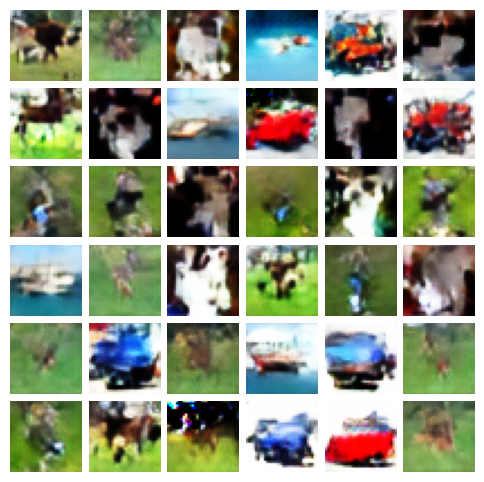

In [49]:
plot_samples(n_samples=36)

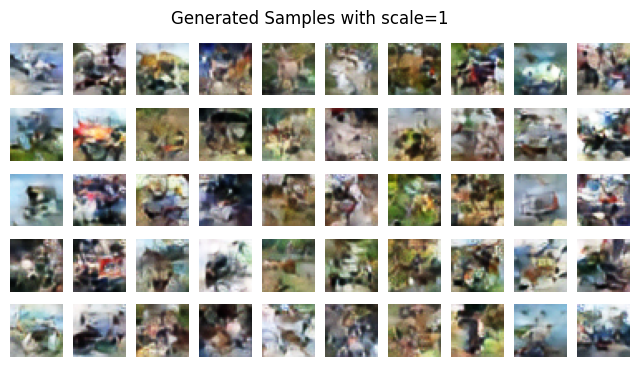

In [51]:
plot_cfg(scale=1)

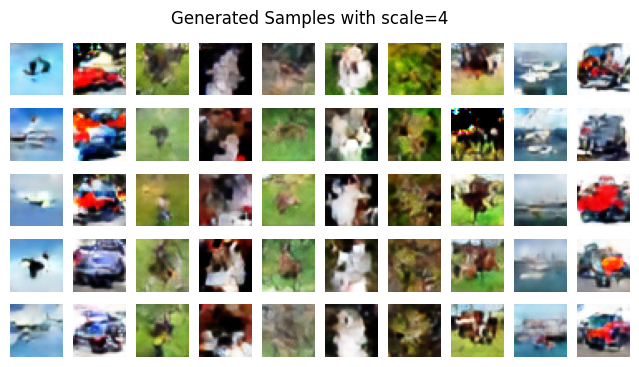

In [52]:
plot_cfg(scale=4)

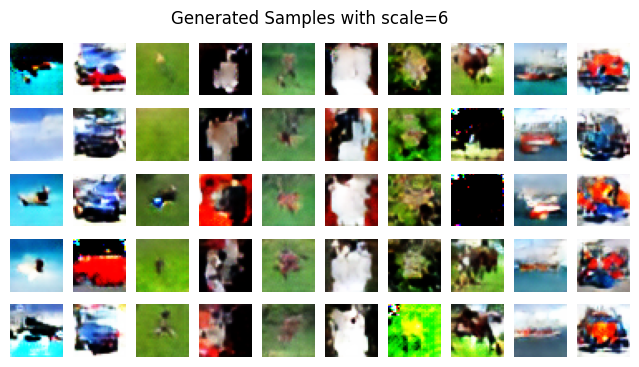

In [54]:
plot_cfg(scale=6)